In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator as imgen
from sklearn.metrics import classification_report,confusion_matrix,mean_absolute_error
from sklearn.utils import class_weight
import seaborn as sns

# Data Loading and Preprocessing

In [2]:
ETHNICITIES = { 0: "White", 1: "Black", 2: "Asian", 3: "Indian", 4: "Hispanic" }
GENDERS = { 0: "Male", 1: "Female" }

In [3]:
df = pd.read_csv('./data/age_gender.csv')

In [4]:
df = df.drop(['img_name'], axis=1)
df["pixels"] = df["pixels"].apply(lambda x: np.array(x.split(),dtype="float32"))
df['pixels'] = df['pixels'].apply(lambda x: x.reshape(48, 48, 1))
df['pixels'] = df['pixels'].apply(lambda x: x / 255.)

In [5]:
df.head()

,age,ethnicity,gender,pixels
0,1,2,0,"[[[0.5058824], [0.5019608], [0.5019608], [0.49..."
1,1,2,0,"[[[0.6431373], [0.2901961], [0.43529412], [0.6..."
2,1,2,0,"[[[0.2627451], [0.27450982], [0.2784314], [0.2..."
3,1,2,0,"[[[0.75686276], [0.77254903], [0.7764706], [0...."
4,1,2,0,"[[[0.7921569], [0.8039216], [0.81960785], [0.8..."


In [6]:
X = np.zeros(shape=(23705, 48, 48, 1))

for ind, row in df.iterrows():
    X[ind, :, :, :] = row['pixels']
    
print(X.shape)

(23705, 48, 48, 1)


# Sample Data Visualization

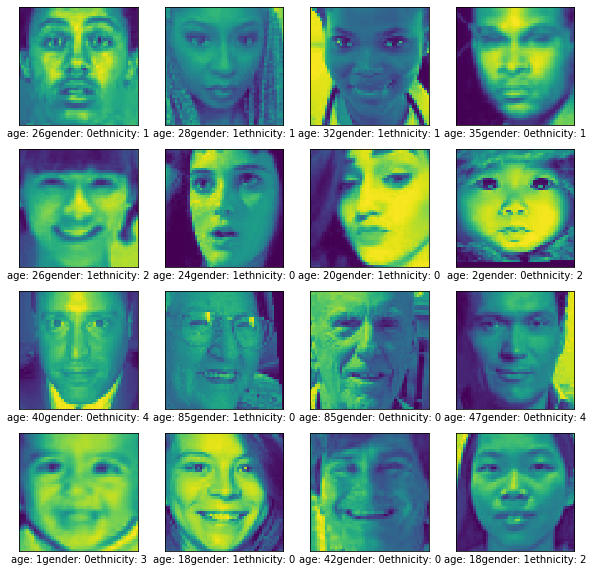

In [7]:
fig = plt.figure(figsize=(10,10))
random_indices = np.random.randint(0, 23705, 16)

for index in range(len(random_indices)):
    
    plt.subplot(4,4, (index%25)+1)
    plt.grid(True)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X[random_indices[index]].reshape(48, 48))
    
    plt.xlabel(f"age: {str(df.age.iloc[random_indices[index]])}" + 
               f"gender: {str(df.gender.iloc[random_indices[index]])}" + 
               f"ethnicity: {str(df.ethnicity.iloc[random_indices[index]])}")
    
plt.show()

# Train Model

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D, Conv2D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

/home/rohit/anaconda3/envs/econ/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/rohit/anaconda3/envs/econ/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/rohit/anaconda3/envs/econ/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/rohit/anaconda3/envs/econ/lib/python3.7/site-pack

## Models

In [148]:
def get_age_classifier_model(input_shape):
    
    model = Sequential()
    model.add(Conv2D(32, (3,3), activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2,2))
    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(MaxPooling2D(2,2))
    model.add(Conv2D(128, (3,3), activation='relu'))
    model.add(MaxPooling2D(2,2))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='relu'))
    
    model.compile(optimizer='adam', loss='mean_squared_error',metrics=['mae'])
    
    return model


def get_ethnicity_classifier_model(input_shape):
    model = Sequential()
    model.add(Conv2D(32, (3,3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(2,2))
    model.add(Conv2D(32, (3,3), activation='relu'))
    model.add(MaxPooling2D(2,2))
    model.add(Dropout(0.3))
    
    model.add(Conv2D(64,(3,3), activation = "relu"))
    model.add(MaxPooling2D(2,2))
    
    model.add(Conv2D(128,(3,3), activation = "relu"))
    model.add(MaxPooling2D(2,2))
    
    model.add(Flatten())
    
    model.add(Dense(256,activation = 'relu'))
    model.add(Dropout(0.5))
    
    
    model.add(Dense(5,activation='softmax'))
    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    
    return model


def get_gender_classifier_model(input_shape):
    model = Sequential([
        Conv2D(32,(3,3), activation = "relu", input_shape = (48,48,1)),
        MaxPooling2D(2,2),

        Conv2D(32,(3,3), activation = "relu"),
        MaxPooling2D(2,2),

        Dropout(0.3),

        Conv2D(64,(3,3), activation = "relu"),
        MaxPooling2D(2,2),

        #Conv2D(128,(3,3), activation = "relu"),
        #MaxPooling2D(2,2),

        Flatten(),

        #Dense(256,activation = 'relu'),
        #Dropout(0.5),

        Dense(64,activation = 'relu'),
        Dropout(0.5),


        Dense(1,activation='sigmoid')
    ])
    
    model.compile(optimizer='adam',loss = "binary_crossentropy",metrics=['accuracy'])
    
    return model



# Train Age Classifier

In [11]:
y = df['age'].values

In [12]:
xTrain, xTest, yTrain, yTest = train_test_split(X,y,train_size=0.8,random_state=42,shuffle=True)

In [13]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3)
checkpoint = tf.keras.callbacks.ModelCheckpoint(monitor='val_accuracy',
                                                save_best_only=True,
                                                filepath="./saved_models/age/best_model")

in_shape = (xTrain.shape[1], xTrain.shape[2], xTrain.shape[3])
model = get_age_classifier_model(in_shape)
age_hist = model.fit(xTrain, yTrain,
                     validation_data=(xTest, yTest),
                     callbacks=[early_stop, checkpoint],
                     batch_size=64,
                     epochs=50)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 18964 samples, validate on 4741 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
18964/18964 [==============================] - 7s 367us/sample - loss: 329.4766 - mean_absolute_error: 13.7487 - val_loss: 1044.0546 - val_mean_absolute_error: 26.7371
Epoch 2/50
18964/18964 [==============================] - 5s 265us/sample - loss: 193.1357 - mean_absolute_error: 10.4636 - val_loss: 335.6141 - val_mean_absolute_error: 13.5828
Epoch 3/50
18964/18964 [==============================] - 5s 261us/sample - loss: 165.1051 - mean_absolute_error: 9.5807 - val_loss: 138.1848 - val_mean_absolute_error: 8.5985
Epoch 4/50
18964/18964 [==============================] - 5s 261us/sample - loss: 149.4926 - mean_absolute_error: 9.0547 - val_loss: 12

18964/18964 [==============================] - 5s 267us/sample - loss: 62.4720 - mean_absolute_error: 5.8441 - val_loss: 129.5346 - val_mean_absolute_error: 8.2831
Epoch 41/50
18964/18964 [==============================] - 5s 267us/sample - loss: 61.3806 - mean_absolute_error: 5.7789 - val_loss: 96.4109 - val_mean_absolute_error: 7.2312
Epoch 42/50
18964/18964 [==============================] - 5s 268us/sample - loss: 60.1326 - mean_absolute_error: 5.7385 - val_loss: 114.3508 - val_mean_absolute_error: 7.7405
Epoch 43/50
18964/18964 [==============================] - 5s 268us/sample - loss: 59.2506 - mean_absolute_error: 5.7316 - val_loss: 99.6692 - val_mean_absolute_error: 7.4438
Epoch 44/50
18964/18964 [==============================] - 5s 268us/sample - loss: 60.0996 - mean_absolute_error: 5.7926 - val_loss: 114.8606 - val_mean_absolute_error: 7.8375
Epoch 45/50
18964/18964 [==============================] - 5s 268us/sample - loss: 57.7879 - mean_absolute_error: 5.6766 - val_loss: 9

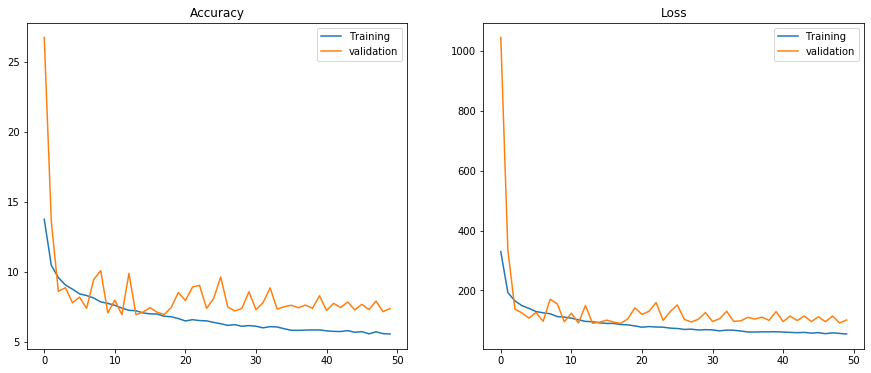

In [15]:
hist_age = age_hist

plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
plt.plot(hist_age.epoch,hist_age.history['mean_absolute_error'],label = 'Training')
plt.plot(hist_age.epoch,hist_age.history['val_mean_absolute_error'],label = 'validation')

plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist_age.epoch,hist_age.history['loss'],label = 'Training')
plt.plot(hist_age.epoch,hist_age.history['val_loss'],label = 'validation')

plt.title("Loss")
plt.legend()
plt.show()



# Evaluate Age Classifier

In [ ]:
mse, mae = model.evaluate(xTest,yTest,verbose=0)
print('Test Mean squared error: {}'.format(mse))
print('Test Mean absolute error: {}'.format(mae))

## Train Ethnicity Classifier

In [136]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3)
checkpoint = tf.keras.callbacks.ModelCheckpoint(monitor='val_acc',
                                                save_best_only=True,
                                                filepath="./saved_models/eth/best_model")

y = df['ethnicity'].values
xTrain, xTest, yTrain, yTest = train_test_split(X,y,train_size=0.7, stratify=y, random_state=42,shuffle=True)

In [137]:
value_counts = df['ethnicity'].value_counts()
value_counts

0    10078
1     4526
3     3975
2     3434
4     1692
Name: ethnicity, dtype: int64

In [138]:
np.unique(yTest)

array([0, 1, 2, 3, 4])

In [139]:
total = value_counts.sum()
total

23705

In [140]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y),
                                                 y)
class_weights

/home/rohit/anaconda3/envs/econ/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3 4], y=[2 2 2 ... 2 2 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


array([0.47043064, 1.04750331, 1.38060571, 1.1927044 , 2.80200946])

In [141]:
in_shape = (xTrain.shape[1], xTrain.shape[2], xTrain.shape[3])
model = get_ethnicity_classifier_model(in_shape)
et_hist = model.fit(xTrain, yTrain,
          validation_data=(xTest, yTest),
          class_weight=class_weights,
          callbacks=[early_stop, checkpoint],
          batch_size=32,
          epochs=25) 

Train on 16593 samples, validate on 7112 samples
Epoch 1/25
16593/16593 [==============================] - 9s 556us/sample - loss: 1.3675 - acc: 0.4654 - val_loss: 1.2105 - val_acc: 0.5295
Epoch 2/25
16593/16593 [==============================] - 5s 284us/sample - loss: 1.0699 - acc: 0.5940 - val_loss: 0.9360 - val_acc: 0.6496
Epoch 3/25
16593/16593 [==============================] - 5s 285us/sample - loss: 0.9330 - acc: 0.6596 - val_loss: 0.8420 - val_acc: 0.6947
Epoch 4/25
16593/16593 [==============================] - 5s 286us/sample - loss: 0.8695 - acc: 0.6878 - val_loss: 0.8055 - val_acc: 0.7096
Epoch 5/25
16593/16593 [==============================] - 5s 285us/sample - loss: 0.8291 - acc: 0.7060 - val_loss: 0.7782 - val_acc: 0.7236
Epoch 6/25
16593/16593 [==============================] - 5s 285us/sample - loss: 0.7927 - acc: 0.7166 - val_loss: 0.7685 - val_acc: 0.7260
Epoch 7/25
16593/16593 [==============================] - 5s 286us/sample - loss: 0.7717 - acc: 0.7254 - val_lo

# Evaluate Ethnicity Classifier

In [142]:
loss, acc = model.evaluate(xTest, yTest, verbose=0)
print('Test loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))

Test loss: 0.6627860183254538
Test Accuracy: 0.7692632079124451


In [143]:
pred_et = model.predict(xTest)

In [144]:
pred_et = [np.argmax(i) for i in pred_et]
pred_et[:5]

[2, 0, 3, 0, 0]

In [145]:
print(classification_report(pred_et,yTest))

              precision    recall  f1-score   support

           0       0.85      0.82      0.83      3155
           1       0.87      0.76      0.81      1561
           2       0.86      0.77      0.81      1149
           3       0.64      0.71      0.67      1076
           4       0.13      0.38      0.19       171

    accuracy                           0.77      7112
   macro avg       0.67      0.69      0.66      7112
weighted avg       0.81      0.77      0.79      7112



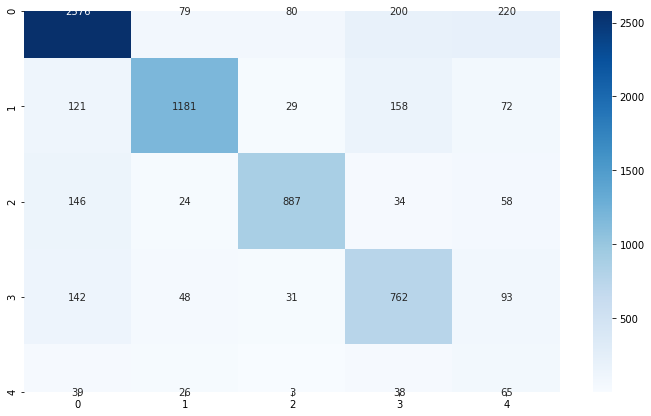

In [146]:
plt.figure(figsize=[12,7])
sns.heatmap(confusion_matrix(pred_et, yTest),annot=True,fmt='d',cmap="Blues");

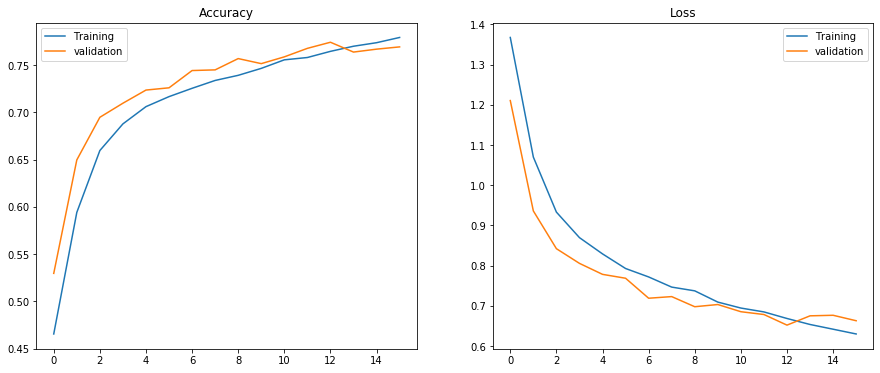

In [147]:
hist_et = et_hist

plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
plt.plot(hist_et.epoch,hist_et.history['acc'],label = 'Training')
plt.plot(hist_et.epoch,hist_et.history['val_acc'],label = 'validation')

plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist_et.epoch,hist_et.history['loss'],label = 'Training')
plt.plot(hist_et.epoch,hist_et.history['val_loss'],label = 'validation')

plt.title("Loss")
plt.legend()
plt.show()


# Train Gender Classifier

In [149]:
y = df['gender'].values
xTrain, xTest, yTrain, yTest = train_test_split(X,y,train_size=0.8,random_state=42,shuffle=True)

In [150]:
in_shape = (xTrain.shape[1], xTrain.shape[2], xTrain.shape[3])
model_gender = get_gender_classifier_model(in_shape)
hist_gender = model_gender.fit(xTrain, yTrain,
                               validation_data=(xTest, yTest),
                               callbacks=[early_stop, checkpoint],
                               batch_size=8,
                               epochs=25)

Train on 18964 samples, validate on 4741 samples
Epoch 1/25
18964/18964 [==============================] - 18s 925us/sample - loss: 0.4927 - acc: 0.7594 - val_loss: 0.3816 - val_acc: 0.8270
Epoch 2/25
18964/18964 [==============================] - 13s 680us/sample - loss: 0.3819 - acc: 0.8283 - val_loss: 0.3401 - val_acc: 0.8445
Epoch 3/25
18964/18964 [==============================] - 13s 660us/sample - loss: 0.3594 - acc: 0.8397 - val_loss: 0.3136 - val_acc: 0.8589
Epoch 4/25
18964/18964 [==============================] - 12s 646us/sample - loss: 0.3392 - acc: 0.8462 - val_loss: 0.2968 - val_acc: 0.8635
Epoch 5/25
18964/18964 [==============================] - 12s 648us/sample - loss: 0.3240 - acc: 0.8549 - val_loss: 0.2876 - val_acc: 0.8760
Epoch 6/25
18964/18964 [==============================] - 12s 643us/sample - loss: 0.3137 - acc: 0.8591 - val_loss: 0.2905 - val_acc: 0.8732
Epoch 7/25
18964/18964 [==============================] - 12s 645us/sample - loss: 0.3065 - acc: 0.8623 -

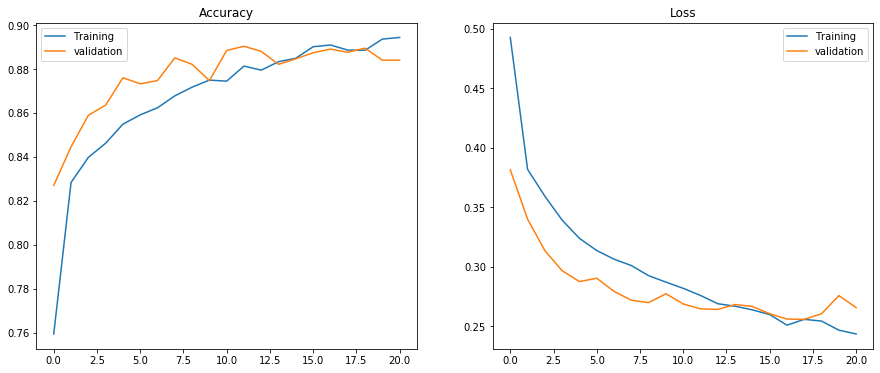

In [151]:


plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
plt.plot(hist_gender.epoch,hist_gender.history['acc'],label = 'Training')
plt.plot(hist_gender.epoch,hist_gender.history['val_acc'],label = 'validation')

plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist_gender.epoch,hist_gender.history['loss'],label = 'Training')
plt.plot(hist_gender.epoch,hist_gender.history['val_loss'],label = 'validation')

plt.title("Loss")
plt.legend()
plt.show()



# Evaluate Gender Classifier

In [152]:
loss, acc = model_gender.evaluate(xTest, yTest, verbose=0)
print('Test loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))

Test loss: 0.265792419364296
Test Accuracy: 0.8839907050132751


In [153]:
pred_gender = model_gender.predict(xTest)

In [154]:
pred_gen = []
for i in pred_gender:
    pred_gen.append(int(np.round(i[0])))

In [155]:
pred_gen[:5]

[1, 0, 1, 0, 0]

In [160]:
print(classification_report(pred_gen,yTest))

              precision    recall  f1-score   support

           0       0.86      0.92      0.88      2308
           1       0.91      0.85      0.88      2433

    accuracy                           0.88      4741
   macro avg       0.89      0.88      0.88      4741
weighted avg       0.89      0.88      0.88      4741



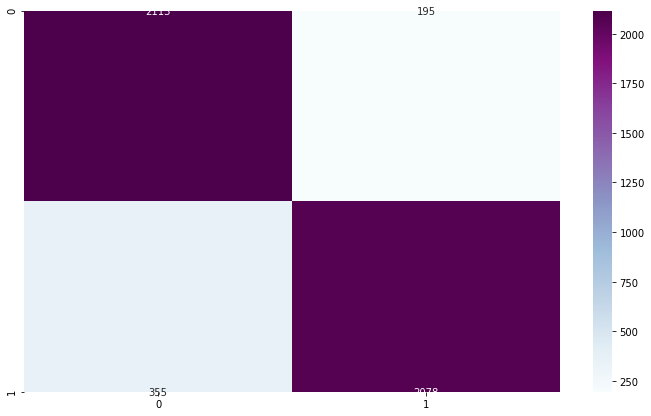

In [163]:
plt.figure(figsize=[12,7])
sns_plot = sns.heatmap(confusion_matrix(pred_gen,yTest),annot = True, fmt = 'd', cmap = "BuPu");

In [162]:
sns_plot.figure.savefig("output.png")